<a href="https://colab.research.google.com/github/vggls/msc_thesis_medical_xai/blob/main/experiments/ham10k_resnet50/ResNet50_training_%26_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports**

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import cv2
import shutil
import torch
import pickle
from torchvision  import datasets, transforms
from torch import nn
import torch.optim as optim
from collections import OrderedDict
from collections import Counter

In [ ]:
# custom written code
from ham10k import map_images_to_paths, create_datasets, summaries #used in sections 3 and 4
from training_loop import Train #imported via train_model
from train_model import fit
from imbalanced import class_weights
from resnet import ResNet
from testing_report import Test_Report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Download data from Kaggle**

In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
# https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
! kaggle datasets download kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [00:29<00:00, 92.9MB/s]
100% 5.20G/5.20G [00:29<00:00, 191MB/s] 


In [ ]:
! unzip skin-cancer-mnist-ham10000.zip

# **3. A first look at the data: Class Distribution**

In [ ]:
metadata = pd.read_csv('HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# Pyogenic Granulomas and Hemorrhage = Vascular lesions
classes = {'akiec': 'Actinic Keratoses (akiec)',
           'bcc': 'Basal Cell Carcinoma (bcc)',
           'bkl': 'Benign Keratosis-like Lesions (bkl)',
           'df': 'Dermatofibroma (df)',
           'nv': 'Melanocytic Nevi (nv)',
           'vasc': 'Vascular lesions (vasc)',
           'mel': 'Melanoma (mel)'}

points = []
names = []
total = 0

for label in classes:
    names.append(classes[label])
    class_points = len([i for i in list(metadata['dx']) if i==label])
    points.append(class_points)
    total += class_points

fig = go.Figure()
for i, clas in enumerate(classes):
    percent = round(points[i] / total * 100, 2)
    text = f"{points[i]} ({percent}%)"
    fig.add_trace(go.Bar(x=[classes[clas]], y=[points[i]], text=[text], textposition='outside', showlegend=False, marker=dict(color="steelblue")))

fig.update_layout(width=900, height=600, title='HAM10000 Dataset: Class distribution', title_x=0.5)
fig.show()

In [ ]:
metadata.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


Above summary suggests that in the dataset there are **10015 unique images coming from 7470 unique lesions**. More specifically, some pictures are **rescaled**.

As a result, while creating the train/val/test datasets (see section 4) we must also **ensure that there is no lesion overlap in the datasets** !

In [ ]:
# calculate frequency distribution - i.e. how many people contribute to each frequency
counts = metadata['lesion_id'].value_counts().to_dict()

counter = Counter(counts.values())

for freq in counter:

    print('{} lesion ids contribute {} image(s) to the dataset'.format(counter[freq], freq))

4 lesion ids contribute 6 image(s) to the dataset
5 lesion ids contribute 5 image(s) to the dataset
34 lesion ids contribute 4 image(s) to the dataset
490 lesion ids contribute 3 image(s) to the dataset
1423 lesion ids contribute 2 image(s) to the dataset
5514 lesion ids contribute 1 image(s) to the dataset


In [ ]:
dataframe = map_images_to_paths()
print(len(dataframe))
dataframe.head()

10015


,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000_images_part_2/ISIC_0031633.jpg


In [ ]:
# list of the images that the lesion id 'HAM_0001863' contributes to the dataset
fourth_key = list(counts.keys())[3]
dataframe[dataframe['lesion_id']==fourth_key]

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
1714,HAM_0001863,ISIC_0032797,mel,histo,70.0,male,upper extremity,HAM10000_images_part_2/ISIC_0032797.jpg
1715,HAM_0001863,ISIC_0032596,mel,histo,70.0,male,upper extremity,HAM10000_images_part_2/ISIC_0032596.jpg
1716,HAM_0001863,ISIC_0032856,mel,histo,70.0,male,upper extremity,HAM10000_images_part_2/ISIC_0032856.jpg
1717,HAM_0001863,ISIC_0033193,mel,histo,70.0,male,upper extremity,HAM10000_images_part_2/ISIC_0033193.jpg
1718,HAM_0001863,ISIC_0033125,mel,histo,70.0,male,upper extremity,HAM10000_images_part_2/ISIC_0033125.jpg
1719,HAM_0001863,ISIC_0032810,mel,histo,70.0,male,upper extremity,HAM10000_images_part_2/ISIC_0032810.jpg


# **4. Create Training, Validation and Test datasets**

In [ ]:
#shutil.rmtree('./training_dataset')
#shutil.rmtree('./validation_dataset')
#shutil.rmtree('./test_dataset')

In [ ]:
# to be applied to training data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])
# to be applied to validation and test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

In [ ]:
train_dataset, validation_dataset, test_dataset= create_datasets(dataframe = dataframe,
                                                                 train_transforms = train_transforms,
                                                                 test_transforms = test_transforms)

In [ ]:
labels = train_dataset.class_to_idx
summaries(labels, bar_plot=True)

# **5. Dataset Visualization**

<Figure size 640x480 with 0 Axes>

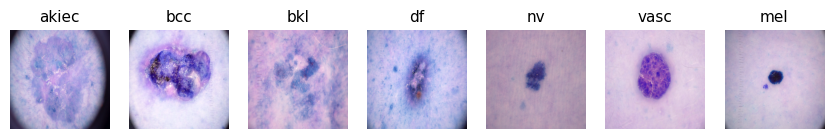

In [ ]:
#indices = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,1)]
indices = [0,1,2,3,4,5,6]

plt.figure()

fig, ax = plt.subplots(1, 7, figsize=(10.5, 1.5))

for index, clas in zip(indices, classes):
    first_class_row = dataframe[dataframe['dx']==clas].iloc[0]
    img_path = first_class_row['image_path']
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    ax[index].imshow(img)
    ax[index].set_title(classes[clas], fontsize=)
    ax[index].axis('off')

plt.show()

# **6. ResNet50**

In [ ]:
weights = class_weights('./training_dataset', train_dataset)

akiec class - instances 198 - assigned weight 0.005050505050505051
bcc class - instances 309 - assigned weight 0.003236245954692557
bkl class - instances 660 - assigned weight 0.0015151515151515152
df class - instances 70 - assigned weight 0.014285714285714285
mel class - instances 669 - assigned weight 0.0014947683109118087
nv class - instances 4024 - assigned weight 0.00024850894632206757
vasc class - instances 86 - assigned weight 0.011627906976744186


In [ ]:
resnet50 = ResNet(type_ = '50',
                       no_of_classes = 7,
                       trainable_layers = [7])

> **training**

In [ ]:
loss_fct = torch.nn.CrossEntropyLoss(weights.cuda())
optimizer = optim.Adam(resnet50.model.parameters(), lr=0.00001, weight_decay=0.1)

training_dict, validation_dict = fit(train_dataset=train_dataset,
                                     validation_dataset=validation_dataset,
                                     batch_size=256,
                                     model=resnet50,
                                     loss_fct=loss_fct,
                                     optimizer=optimizer,
                                     scheduler=None,
                                     epochs=100,
                                     patience=20,
                                     no_of_classes=7,
                                     labels_of_normal_classes=None)

Device: cuda:0
Starting training..
-----------------------------------
Epoch 1/100
->Training phase
  Loss=1.7078
  Accuracy=0.4 - Recall per class=[0.37, 0.31, 0.3, 0.16, 0.37, 0.44, 0.62]
->Validation phase
  Loss=1.6013
  Accuracy=0.54 - Recall per class=[0.42, 0.55, 0.37, 0.46, 0.52, 0.57, 0.86]
->New model saved!
-----------------------------------
Epoch 2/100
->Training phase
  Loss=1.2258
  Accuracy=0.6 - Recall per class=[0.61, 0.61, 0.42, 0.53, 0.55, 0.63, 0.88]
->Validation phase
  Loss=1.1824
  Accuracy=0.55 - Recall per class=[0.45, 0.76, 0.44, 0.54, 0.49, 0.56, 0.97]
->New model saved!
-----------------------------------
Epoch 3/100
->Training phase
  Loss=0.9900
  Accuracy=0.65 - Recall per class=[0.68, 0.68, 0.51, 0.69, 0.53, 0.68, 0.91]
->Validation phase
  Loss=1.0439
  Accuracy=0.57 - Recall per class=[0.41, 0.79, 0.54, 0.71, 0.52, 0.57, 0.97]
->New model saved!
-----------------------------------
Epoch 4/100
->Training phase
  Loss=0.8685
  Accuracy=0.67 - Recall per

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training complete !


In [ ]:
import pickle
drive_path = './drive/MyDrive/Colab_Notebooks/dataset_models/HAM10000/Models/'
with open(drive_path + 'ham10k_resnet50_training_dict.pickle', 'wb') as f:
  pickle.dump(training_dict, f)
with open(drive_path + 'ham10k_resnet50_validation_dict.pickle', 'wb') as f:
  pickle.dump(validation_dict, f)

> **loss history plot**

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(training_dict['loss'])+1 )), y=training_dict['loss'], name='Training'))
fig.add_trace(go.Scatter(x=list(range(1, len(validation_dict['loss'])+1 )), y=validation_dict['loss'], name='Validation'))
fig.update_layout(title='ResNet50 Loss history (Optimal model at epoch 26)',
                  title_x=0.5,
                   xaxis_title='Epochs',
                   yaxis_title='Loss',
                  height=400, width=800,)
fig.show()

> **testing**

In [ ]:
drive_path = './drive/MyDrive/Colab_Notebooks/dataset_models/HAM10000/Models/'
resnet50 = torch.load(drive_path + 'ham10k_resnet50.pt')

from torch.utils.data import DataLoader
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

test_report = Test_Report(test_loader, resnet50, test_dataset.class_to_idx.keys())

Device: cuda:0


In [ ]:
print('\033[1m' + 'Model: ham10k_resnet50.pt' + '\033[0m \n')
test_report.classification_report()
bal_acc=test_report.balanced_accuracy()
print(f'Balanced Accuracy Score: {round(bal_acc, 2)}')

Model: ham10k_resnet50.pt 

              precision    recall  f1-score   support

       akiec       0.44      0.75      0.55        63
         bcc       0.59      0.75      0.66       102
         bkl       0.50      0.71      0.59       219
          df       0.24      0.43      0.31        21
         mel       0.37      0.63      0.47       221
          nv       0.96      0.71      0.82      1339
        vasc       0.59      0.81      0.69        27

    accuracy                           0.71      1992
   macro avg       0.53      0.69      0.58      1992
weighted avg       0.80      0.71      0.73      1992

Balanced Accuracy Score: 0.69


In [ ]:
print('\033[1m' + 'Model: ham10k_resnet50.pt' + '\033[0m')
scores = test_report.roc_curve_and_scores(plot=True)
print(f'Mean AUC score: {round(sum(scores)/len(scores),3)}')
_ = test_report.pr_curve_and_scores(plot=True)

Model: ham10k_resnet50.pt


Mean AUC score: 0.934
